1\. **PCA on 3D dataset**

* Generate a dataset with 3 features each with N entries (N being ${\cal O}(1000)$). With $N(\mu,\sigma)$ the normali distribution with mean $\mu$ and $\sigma$  standard deviation, generate the 3 variables $x_{1,2,3}$ such that:
    * $x_1$ is distributed as $N(0,1)$
    * $x_2$ is distributed as $x_1+N(0,3)$
    * $x_3$ is given by $2x_1+x_2$
* Find the eigenvectors and eigenvalues of the covariance matrix of the dataset
* Find the eigenvectors and eigenvalues using SVD. Check that the two procedures yield to same result
* What percent of the total dataset's variability is explained by the principal components? Given how the dataset was constructed, do these make sense? Reduce the dimensionality of the system so that at least 99% of the total variability is retained.
* Redefine the data in the basis yielded by the PCA procedure
* Plot the data points in the original and the new coordiantes as a set of scatter plots. Your final figure should have 2 rows of 3 plots each, where the columns show the (0,1), (0,2) and (1,2) proejctions.


(3, 3000)


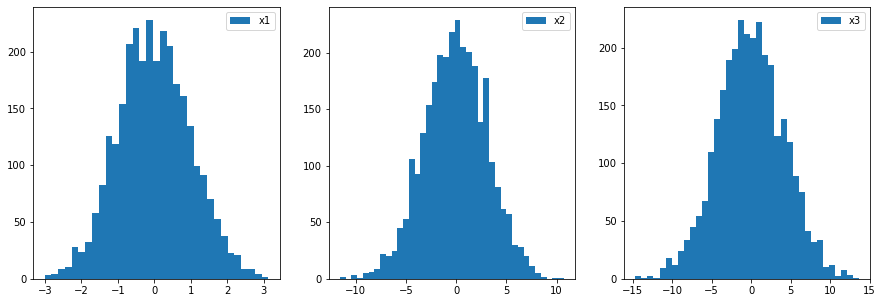

In [1]:
import numpy as np
import scipy as sp
from scipy import linalg as la
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

ID = 2044719
np.random.seed(ID)

N = 3000
x1 = np.random.normal(0, 1, N)
x2 = x1 + np.random.normal(0, 3, N)
x3 = 2*x1 + x2

# data matrix
X = np.array([x1, x2, x3])
print(X.shape)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
ax[0].hist(x1, bins='auto', label='x1')
ax[0].legend()
ax[1].hist(x2, bins='auto', label='x2')
ax[1].legend()
ax[2].hist(x3, bins='auto', label='x3')
ax[2].legend()
plt.show()

In [2]:
# covariance matrix
C = np.cov(X)
# eigendecomposition
l, V = la.eig(C)

print("EIGENDECOMPOSITION")
print("\ncovariance matrix:\n", C)
print("\neigenvalues:\n", np.real_if_close(l))
print("\neigenvectors:\n", V)

EIGENDECOMPOSITION

covariance matrix:
 [[ 0.97468027  0.93939044  2.88875098]
 [ 0.93939044  9.65861983 11.53740072]
 [ 2.88875098 11.53740072 17.31490267]]

eigenvalues:
 [ 2.59776775e+01 -2.36635568e-16  1.97052529e+00]

eigenvectors:
 [[-0.11506227 -0.81649658  0.56576851]
 [-0.57785981 -0.40824829 -0.70669043]
 [-0.80798435  0.40824829  0.42484659]]


In [3]:
# SVD decomposition
U, spectrum, Vt = la.svd(X)
# covariance matrix
C_svd = np.dot(X, X.T)/(N-1)
# eigenvalues
l_svd = spectrum**2/(N-1)
# eigenvectors
V_svd = U

print("SVD")
print("\ncovariance matrix:\n", C_svd)
print("\neigenvalues:\n", l_svd)
print("\neigenvectors:\n", V_svd)

SVD

covariance matrix:
 [[ 0.97471202  0.9398214   2.88924545]
 [ 0.9398214   9.66446847 11.54411128]
 [ 2.88924545 11.54411128 17.32260218]]

eigenvalues:
 [2.59910731e+01 1.97070955e+00 1.94748225e-31]

eigenvectors:
 [[-0.11502525  0.56577604 -0.81649658]
 [-0.57790605 -0.70665263 -0.40824829]
 [-0.80795655  0.42489945  0.40824829]]


diagonalized covariance matrix:
 [[2.59910731e+01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.97070955e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.94748225e-31]]
X.trace(): 27.948202765995383
L.trace(): 27.96178267127644


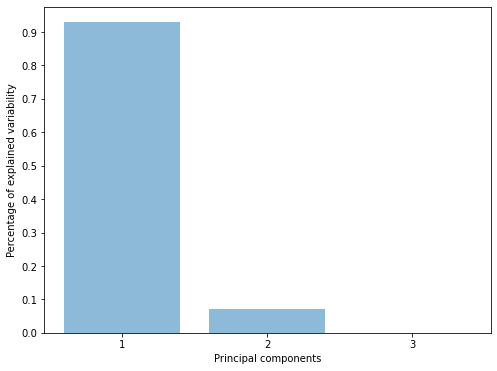

True

In [4]:
# I chose the SVD to construct the diagonalized covariance matrix because
# it provides the eigenvalues already sorted from largest to smallest.
L = np.diag(l_svd)
print("diagonalized covariance matrix:\n", L)
print("X.trace():", np.cov(X).trace())
print("L.trace():", L.trace())

# variability explained by each principal component 
grid = np.arange(len(l_svd))
labels = [str(i) for i in range(1,4)]
variability = np.array([ l/L.trace() for l in l_svd])

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(grid, variability, align='center', alpha=0.5)
ax.set_xlabel('Principal components')
ax.set_ylabel('Percentage of explained variability')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
# set the tick positions
ax.set_xticks(grid)
# set the tick labels
ax.set_xticklabels(labels)
plt.show()

variability[0:2].sum() >= 0.99
# To retain at least 99% of the total variability we need to consider
# the first two principal components. This makes sense because the third feature
# is just a linear combination of the first two and therefore does not add new information

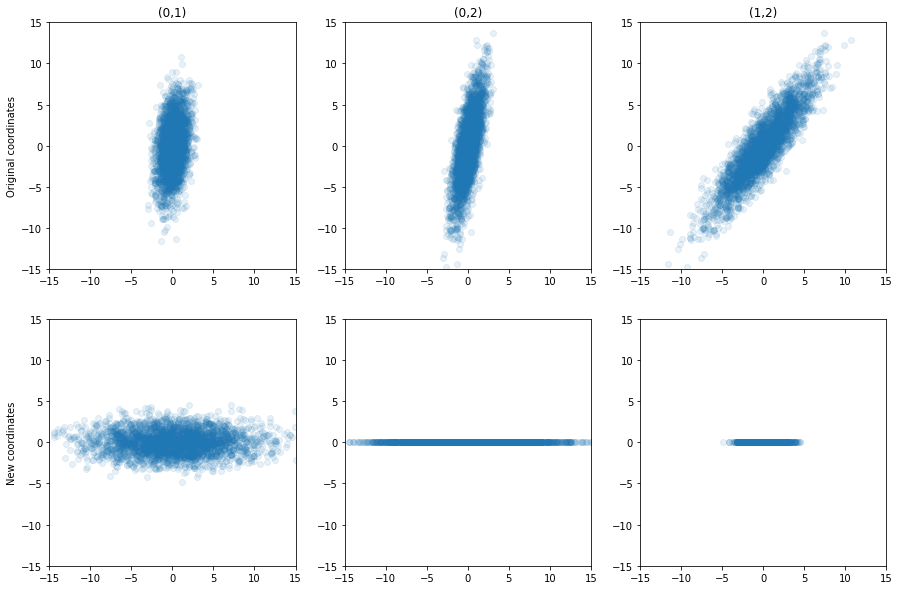

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
Xp = np.dot(V_svd.T, X)

# original coordiantes

ax[0,0].scatter(X[0], X[1], alpha=0.1)
ax[0,0].set_xlim(-15, 15)
ax[0,0].set_ylim(-15, 15)
ax[0,0].set_ylabel("Original coordinates")
ax[0,0].set_title('(0,1)')

ax[0,1].scatter(X[0], X[2], alpha=0.1)
ax[0,1].set_xlim(-15, 15)
ax[0,1].set_ylim(-15, 15)
ax[0,1].set_title('(0,2)')

ax[0,2].scatter(X[1], X[2], alpha=0.1)
ax[0,2].set_xlim(-15, 15)
ax[0,2].set_ylim(-15, 15)
ax[0,2].set_title('(1,2)')

# new coordiantes

ax[1,0].scatter(Xp[0], Xp[1], alpha=0.1)
ax[1,0].set_xlim(-15, 15)
ax[1,0].set_ylim(-15, 15)
ax[1,0].set_ylabel("New coordinates")

ax[1,1].scatter(Xp[0], Xp[2], alpha=0.1)
ax[1,1].set_xlim(-15, 15)
ax[1,1].set_ylim(-15, 15)

ax[1,2].scatter(Xp[1], Xp[2], alpha=0.1)
ax[1,2].set_xlim(-15, 15)
ax[1,2].set_ylim(-15, 15)

plt.show()

2\. **PCA on a nD dataset**

Start from the dataset you have genereted in the previous exercise and add uncorrelated random noise. Such noise should be represented by other 10 uncorrelated variables normal distributed, with standar deviation much smaller (say, a factor 50) than those used to generate the $x_1$ and $x_2$.

Repeat the PCA procedure and compare the results with what you obtained before

In [6]:
n = 10
noise = np.zeros((n,N))
sigma = np.random.random(10)/50.0
print(sigma)
for i in range(10):
    noise[i] = np.random.normal(0, sigma[i], N)
    
# new data matrix with noise
Y = np.append(X, noise, axis=0)
Y.shape

[0.01369072 0.00605576 0.01125925 0.00104103 0.00995883 0.00895373
 0.00123155 0.01672567 0.01881896 0.01533832]


(13, 3000)

In [7]:
# SVD decomposition
U, spectrum, Vt = la.svd(Y)
# covariance matrix
C_svd = np.dot(Y, Y.T)/(N-1)
# eigenvalues
l_svd = spectrum**2/(N-1)
# eigenvectors
V_svd = U

print("\neigenvalues:\n", l_svd)


eigenvalues:
 [2.59910734e+01 1.97071038e+00 3.55645876e-04 2.65978539e-04
 2.20491363e-04 1.80306389e-04 1.30196172e-04 9.74024931e-05
 7.93277467e-05 3.75227442e-05 1.48590351e-06 1.09472777e-06
 1.93436179e-31]


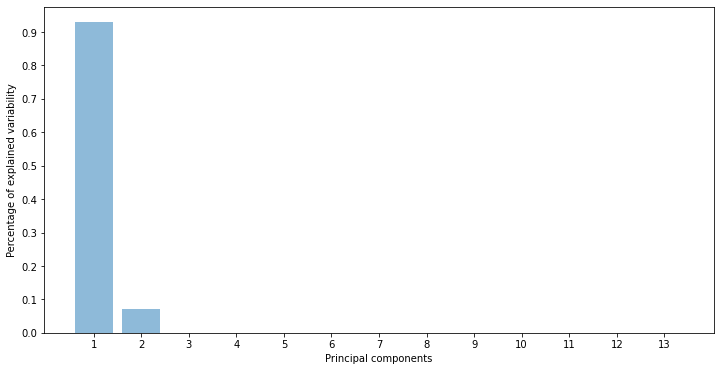

True

In [8]:
# variability explained by each principal component 
grid = np.arange(len(l_svd))
labels = [str(i) for i in range(1,14)]
variability = np.array([ l/L.trace() for l in l_svd])

fig, ax = plt.subplots(figsize=(12,6))
ax.bar(grid, variability, align='center', alpha=0.5)
ax.set_xlabel('Principal components')
ax.set_ylabel('Percentage of explained variability')
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter("%d"))
ax.yaxis.set_major_locator(MultipleLocator(0.1))
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
# set the tick positions
ax.set_xticks(grid)
# set the tick labels
ax.set_xticklabels(labels)
plt.show()

variability[0:2].sum() >= 0.99

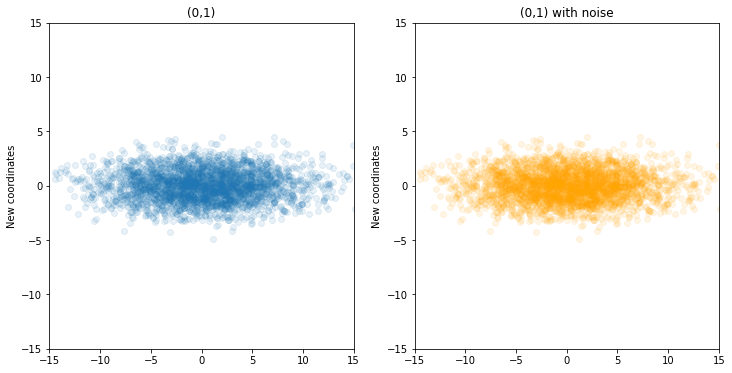

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
Yp = np.dot(V_svd.T, Y)

# original coordiantes

ax[0].scatter(Xp[0], Xp[1], alpha=0.1)
ax[0].set_xlim(-15, 15)
ax[0].set_ylim(-15, 15)
ax[0].set_ylabel("New coordinates")
ax[0].set_title('(0,1)')

# new coordiantes

ax[1].scatter(Yp[0], Yp[1], alpha=0.1, c='orange')
ax[1].set_xlim(-15, 15)
ax[1].set_ylim(-15, 15)
ax[1].set_ylabel("New coordinates")
ax[1].set_title('(0,1) with noise')

plt.show()

# Also in this case more than 99% of the variability is explained by the two principal components
# associated with the same eigenvalues obtained with the previous dataset.

3 \. **Looking at an oscillating spring** (optional)

Imagine you have $n$ cameras looking at a spring oscillating along the $x$ axis. Each  camera record the motion of the spring looking at it along a given direction defined by the pair $(\theta_i, \phi_i)$, the angles in spherical coordinates. 

Start from the simulation of the records (say ${\cal O}(1000)$) of the spring's motion along the x axis, assuming a little random noise affects the measurements along the $y$. Rotate such dataset to emulate the records of each camera.

Perform a Principal Component Analysis on the thus obtained dataset, aiming at finding the only one coordinate that really matters.


4\. **PCA on the MAGIC dataset** (optional)

Perform a PCA on the magic04.data dataset

In [10]:
# get the dataset and its description on the proper data directory
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data -P ~/data/
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names -P ~/data/ 

--2021-12-11 20:02:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1477391 (1,4M) [application/x-httpd-php]
Saving to: ‘/home/sgorla/data/magic04.data.1’

magic04.data.1      100%[===================>]   1,41M   997KB/s    in 1,4s    

2021-12-11 20:02:12 (997 KB/s) - ‘/home/sgorla/data/magic04.data.1’ saved [1477391/1477391]

--2021-12-11 20:02:12--  https://archive.ics.uci.edu/ml/machine-learning-databases/magic/magic04.names
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5400 (5,3K) [application/x-httpd-php]
Saving to: ‘/home/sgorla/data/magic04.names.1’

magic04.names.1  